### Sentiment analysis of US Airlines tweets

Interpreting and classifying opinions and emotions in subjective data is referred to as sentiment analysis. Sentiment analysis of customer experience is applied in various industries, such as finance, business, politics, and risk assessment. There are  various machine learning, artificial intelligence, and deep learning techniques. In this project machine leargning models are created and configured for optimal predictive analysis of customers' tweets.


### Business understanding

Social media can be used to gather insight in customer' satisfaction and it's fluctuation in different locations or periods of time. Collected data can be used to analyze the fedback and imporove servives and products.

Tweeter is a powerful source of information. Once extracted and processed data from tweeter can offer valuable insight for businesses regarding their performance. 

Customer’s experience is an important issue for the air-travel industry in particular. Twitter is a popular platform for travellers to share their feedback. Airline companies invest time and resources to enhance customer loyalty. By exploring customer feedback, specifically negative feedback, airlines can allocate resources to the weak areas of customer satisfaction, increasing economic and social development of the company. 

Without the use of machine learning and artificial intelligence, orthodox businesses spend hours of human effort completing manual annotations of tweets to group them into positive/negative sentiments, thus increasing the Time to insights. Moreover, errors that occur from humans can affect the manual text tagging accuracy, such errors can result from fatigue or overconfidence. However, computer aided Text Analysis (NLP) can reduce this time to a few minutes.


The goal of this project is to classify twitter data using machine learning and natural language processing (NLP)
The tweets are categorized into neutral, positive, negative sentiments. With use of maching learning algorithms like XXXXXX
we will predict the correct clasification of tweets directed at different airlines, and then test the model on live tweets.

### Data

Dataset: The dataset is borrowed from Kaggle @ https://www.kaggle.com/crowdflower/twitter-airline-sentiment . The datafile is available in this repo in folder Data

### Task
The goal of this project is to provide airlines with tools to correctly identify tweets expressing negative sentiment in order to further analyze the cause of such tweets and use the data to improve their performance.

### Necessary import statements

In [86]:
import pandas as pd
import numpy as np
import re

from sklearn import svm
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score, precision_score

from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import seaborn as sns
import matplotlib.pyplot as plt


Emojis have become meaningful and important in communicating information. We are going to use the Python Emoji module in this project in order to conver emojis into words to be able to further preprocess them.

The main purpose of this package is converting unicode emoji to emoji names and vice versa with emojize() and demojize().

Further information can be found here https://carpedm20.github.io/emoji/docs/

In [2]:
# pip install emoji 
import emoji

### EDA

Exploratory data analysis is importan for deeper understanding of data and its' features and structure

In [3]:
tweets = pd.read_csv('Data/Tweets.csv')

Looking into NA values in the dataset

In [4]:
#Some column are missing a large percentage of values
tweets.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Majority of tweets are negative

In [5]:
tweets.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

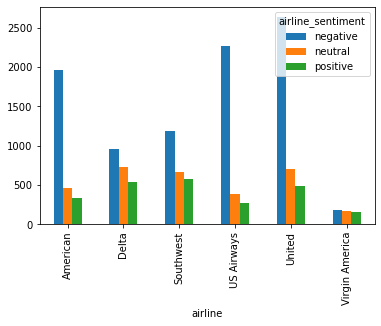

In [6]:
sentiments = (tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack())
sentiments.plot(kind='bar');

Leading reasons for negative feedback is Customer Service Issue and Late Flights

In [7]:
tweets['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

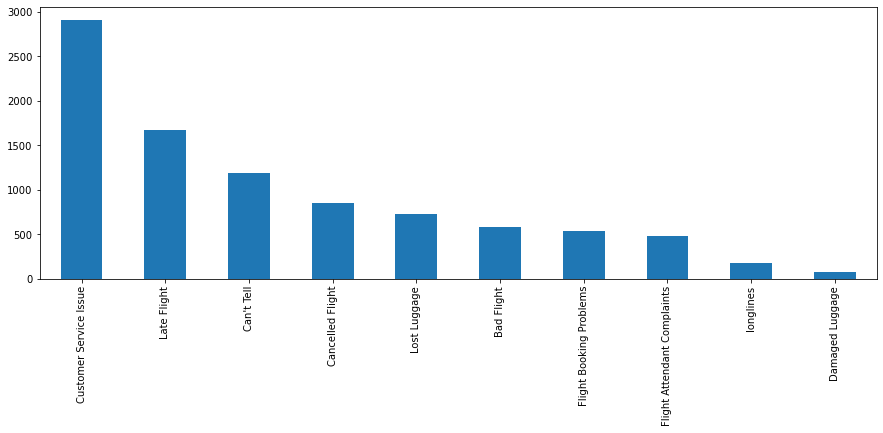

In [8]:
#main reason for negative tweets is customer services or Late or cancelled flight
tweets.negativereason.value_counts().plot(kind='bar', figsize=(15,5));

For this project we will only use the names of the airlines and text of the tweet as our features

### Data cleaning and preprocessing
In order to perform sentiment analysis we will need to focus on meaningful features like tweet text and Airline names.
We will focus on sentiments with 100% confidence score. Further testing showed higher final model performance when trained on tweets with high confidence score. We will remove unneeded columns and use preprocessing function to remove URLs, punctuation, replace numbers, and lemmatize our text.

In [9]:
#Dropping unnecessary columns
tweets.drop('negativereason_gold', axis=1, inplace=True)
tweets.drop('airline_sentiment_gold', axis=1, inplace=True)
tweets.drop('retweet_count', axis=1, inplace=True)
tweets.drop('tweet_created', axis=1, inplace=True)
tweets.drop('user_timezone', axis=1, inplace=True)
tweets.drop('name', axis=1, inplace=True)
tweets.drop('tweet_id', axis=1, inplace=True)
tweets.drop('negativereason', axis=1, inplace=True)
tweets.drop('tweet_coord', axis=1, inplace=True)
tweets.drop('tweet_location', axis=1, inplace=True)
tweets.drop('negativereason_confidence', axis=1, inplace=True)

#current list of columns
list(tweets.columns)

['airline_sentiment', 'airline_sentiment_confidence', 'airline', 'text']

In [10]:
tweets['airline_sentiment_confidence'].value_counts()

1.0000    10445
0.6667       71
0.6632       35
0.6559       30
0.6596       30
          ...  
0.3913        1
0.7273        1
0.6353        1
0.6260        1
0.3544        1
Name: airline_sentiment_confidence, Length: 1023, dtype: int64

Decision is made to focus on sentiments with 100%. 
Further exploratory analysis showed improved performance using tweets with 100% confidence in comparizon to 70% or 80%

In [11]:
tweets = tweets[tweets['airline_sentiment_confidence'] == 1]

In [12]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10445 entries, 0 to 14638
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             10445 non-null  object 
 1   airline_sentiment_confidence  10445 non-null  float64
 2   airline                       10445 non-null  object 
 3   text                          10445 non-null  object 
dtypes: float64(1), object(3)
memory usage: 408.0+ KB


In [13]:
##Translate nltk POS to wordnet tags for lemmatizer
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

Preprocessing function. 

Decision is made to use WordNetLemmatizer rather than Stemmer. Additional testing showed no significant difference in performance between stemmed and lematized corpus on final model training set cross validation.

Decision is made to include stopwords in training set as additional testing on final model train set cross validation showed decreased performance when ommiting stopwords.

Numbers are substituted with string 'number' as it is still meaningful in the context of final model performance as opposed to ommiting them.

In [14]:
lemmatizer = WordNetLemmatizer() #lemmatizing

def process_text(text):
    doc = text.lower()
    doc = re.sub(r'@\w+', '', doc) # Remove @s
    doc = re.sub(r'#', '', doc) # Remove hashtags
    doc = re.sub(r':', ' ', emoji.demojize(doc)) # Turn emojis into words
    doc = re.sub(r'http\S+', '',doc) # Remove URLs
    doc = re.sub(r'\$\S+', 'dollar', doc) # Change dollar amounts to dollar
    doc = re.sub(r'[^a-z0-9\s]', '', doc) # Remove punctuation
    doc = re.sub(r'[0-9]+', 'number', doc) # Change number values to 'number'
    
    doc = word_tokenize(doc)
#     doc = [word for word in doc if word not in sw]
   
    
    doc = pos_tag(doc)

    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]

    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc] 

    return ' '.join(doc)

In [15]:
# Creating column with preprocessed tweets
tweets['processed_text'] = tweets['text'].map(process_text)

In [16]:
tweets['text'][0]

'@VirginAmerica What @dhepburn said.'

In [17]:
tweets['processed_text'][0]

'what say'

In [18]:
#encoding Airline names in order to include them in model training
dummied_airlines = pd.get_dummies(tweets['airline'])

In [19]:
tweets = tweets.join(dummied_airlines)

In [20]:
tweets.columns

Index(['airline_sentiment', 'airline_sentiment_confidence', 'airline', 'text',
       'processed_text', 'American', 'Delta', 'Southwest', 'US Airways',
       'United', 'Virgin America'],
      dtype='object')

## Vectorizing
For vectorizing TfidfVectorizer is chosen because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. It is subsequently tested in the beginning phase of modeling with different hyperparameters to select the best one.

In [60]:
X = tweets.drop(columns=['airline_sentiment_confidence', 'airline',
       'text', 'airline_sentiment'], axis =1)
y = tweets['airline_sentiment']

In [61]:
#running our train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.20)

In [23]:
#Tested with different hyper parameters with Logistic Regression model below
vectorizer = TfidfVectorizer(input='content')

In [24]:
#Vectorizing train dataset
sparse_out = vectorizer.fit_transform(X_train['processed_text'])
tfidf_df_train = pd.DataFrame(data = sparse_out.toarray(),
                        columns = vectorizer.get_feature_names(), index = X_train.index)

X_train_vec = X_train.drop(['processed_text'], axis=1,).join(tfidf_df_train)

In [25]:
#Vectorizing test set
sparse_out1 = vectorizer.transform(X_test['processed_text'])
tfidf_df_test = pd.DataFrame(data = sparse_out1.toarray(),
                        columns = vectorizer.get_feature_names(), index = X_test.index)

X_test_vec = X_test.drop(['processed_text'], axis=1).join(tfidf_df_test)
X_test_vec = X_test_vec.fillna(value=0)

In [26]:
#comparing shapes
print("X_train shape",X_train_vec.shape)
print("X_test shape",X_test_vec.shape)

X_train shape (8356, 8748)
X_test shape (2089, 8748)


## Modeling

For modeling we will use DummyClassifier() as our base model, Support Vector Classifier, Naive Bayes, and Logistic regression.
We will then tune Vectorizer hyperparameters and run gridsearch on our strongest model to further optimize its' performance.

### Dummy classifier

In [27]:
##checking our dummy/base model score
dc = DummyClassifier(strategy='stratified')
dc.fit(X_train_vec, y_train)

print('Base Model cross validation accuracy', cross_val_score(dc, X_train_vec, y_train).mean().round(2))

Base Model cross validation accuracy 0.54


### Support Vector Classifier

In [147]:
##checking our Support Vector Classifier model score
svc = svm.SVC() #Grid search ()
svc.fit(X_train_vec, y_train)

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-4)]: Done   2 out of   5 | elapsed: 10.2min remaining: 15.3min
[Parallel(n_jobs=-4)]: Done   5 out of   5 | elapsed: 10.3min finished


Base Model accuracy score 0.84


In [148]:
svc_pred_train= svc.predict(X_train_vec)

In [49]:
print('SVC Model cross validation accuracy', cross_val_score(svc, X_train_vec, y_train, n_jobs=-4).mean().round(2))
print('SVC Model accuracy score on train set', accuracy_score(y_train, svc_pred_train).round(2))

0.9500418310027489

### Logistic Regression|

In [28]:
lr = LogisticRegression(max_iter=150) #max iterations-change; l2 or l1 - Grid search (l1, l2, C=[.1, 1, 10])  # Suppose .1 is best, then for Round #2 C=[.03, .1, .3
lr.fit(X_train_vec, y_train)

LogisticRegression(max_iter=150)

In [29]:
lr_pred_train= lr.predict(X_train_vec)
print('Logistic Regression cross validation accuracy', cross_val_score(lr, X_train_vec, y_train, n_jobs=-4).mean().round(3))
print('Logistic Regression accuracy score on train set', accuracy_score(y_train, lr_pred_train).round(3))

Logistic Regression cross validation accuracy 0.868
Logistic Regression accuracy score on train set 0.927


### Naive Bayes

In [159]:
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

MultinomialNB()

In [162]:
nb_pred_train = nb.predict(X_train_vec)
print('Naive Bayes cross validation accuracy', cross_val_score(nb, X_train_vec, y_train, n_jobs=-4).mean().round(3))
print('Naive Bayes accuracy score on train set', accuracy_score(y_train, nb_pred_train).round(3))

Naive Bayes cross validation accuracy 0.743
Naive Bayes accuracy score on train set 0.774


### Vectorizing parameters change
Testing the performance of tuned TfidfVectorizer with Logistic Regression model to find optimal hyperparameters for our vectorizer.

TfidfVectorizer with max_df=2000 and min_df=10 to combat overfitting is a less overfit and more accurate Vectorizer. Accuracy on cross validation is 0.876 compared to 0.868 seen previosly. We will use it with our final model.

In [62]:
final_vectorizer = TfidfVectorizer(input='content', max_df=2000, min_df=10)
sparse_out = final_vectorizer.fit_transform(X_train['processed_text'])
tfidf_df_train = pd.DataFrame(data = sparse_out.toarray(),
                        columns = final_vectorizer.get_feature_names(), index = X_train.index)

X_train_vec = X_train.drop(['processed_text'], axis=1,).join(tfidf_df_train)

In [63]:
sparse_out1 = final_vectorizer.transform(X_test['processed_text'])
tfidf_df_test = pd.DataFrame(data = sparse_out1.toarray(),
                        columns = final_vectorizer.get_feature_names(), index = X_test.index)

X_test_vec = X_test.drop(['processed_text'], axis=1).join(tfidf_df_test)
X_test_vec = X_test_vec.fillna(value=0)

In [64]:
lr2 = LogisticRegression(max_iter=150) 
lr2.fit(X_train_vec, y_train)
print('Logistic Regression cross validation with tuned Vectorizer', cross_val_score(lr2, X_train_vec, y_train, n_jobs=-4).mean().round(3))
lr2_pred_train= lr2.predict(X_train_vec)
print('Accuracy score on train set', accuracy_score(y_train, lr2_pred_train).round(3))

Logistic Regression cross validation with tuned Vectorizer 0.876
Accuracy score on train set 0.909


Tuning ngram_range to include bigrams and trigrams doesn't show improved performance compared to previos vectorizer, and is more overfit.

In [33]:
vectorizer = TfidfVectorizer(input='content', max_df=2000, min_df=10, ngram_range=(1, 3))
sparse_out = vectorizer.fit_transform(X_train['processed_text'])
tfidf_df_train3 = pd.DataFrame(data = sparse_out.toarray(),
                        columns = vectorizer.get_feature_names(), index = X_train.index)

X_train_vec3 = X_train.drop(['processed_text'], axis=1,).join(tfidf_df_train3)

In [34]:
lr3 = LogisticRegression(max_iter=150) #max iterations-change; l2 or l1 - Grid search (l1, l2, C=[.1, 1, 10])  # Suppose .1 is best, then for Round #2 C=[.03, .1, .3
lr3.fit(X_train_vec3, y_train)
print('Logistic Regression cross validation with Vectorizer with tuned ngram range', cross_val_score(lr3, X_train_vec, y_train, n_jobs=-4).mean().round(3))
lr3_pred_train= lr3.predict(X_train_vec3)
print('Accuracy score on train set', accuracy_score(y_train, lr3_pred_train).round(3))

Logistic Regression cross validation with Vectorizer with tuned ngram range 0.876
Accuracy score on train set 0.921


### Logistic regression gridsearch
After initial modeling we chose Logistic regression model for this project for its' strong performance.
We will use GridSearch to find the best parameters for this model with our tuned Vectorizer.

In [193]:
#l2 or l1 
#C=[.1, 1, 10])  
#round 2 will zoom in around best C parameter on a more granular level

parameters = {'penalty':['l1', 'l2', 'elasticnet'], 'C': [.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

lrgrid1 = GridSearchCV(estimator=lr2, param_grid=parameters, cv=5, n_jobs=-4)
lrgrid1.fit(X_train_vec, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=150), n_jobs=-4,
             param_grid={'C': [0.1, 1, 10],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [196]:
lrgrid1.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

In [197]:
lrgrid1_pred_train= lrgrid1.best_estimator_.predict(X_train_vec)
print('Grid search #1 train set accuracy is', accuracy_score(y_train, lrgrid1_pred_train).round(3))
print('Grid search #1 accuracy is', lrgrid1.best_score_.round(3))

Grid search #1 train set accuracy is 0.935
Grid search #1 cross validation accuracy is 0.879


In [198]:
#Zoom in around best C parameter on a more granular level
parameters = {'penalty':['l1', 'l2', 'elasticnet'], 'C': [5, 10, 15], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

lrgrid2 = GridSearchCV(estimator=lr2, param_grid=parameters, cv=5, n_jobs=-4)
lrgrid2.fit(X_train_vec, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=150), n_jobs=-4,
             param_grid={'C': [5, 10, 15],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [199]:
lrgrid2.best_params_

{'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}

In [202]:
lrgrid2_pred_train= lrgrid2.best_estimator_.predict(X_train_vec)
print('Grid search #2 train set accuracy is', accuracy_score(y_train, lrgrid2_pred_train).round(3))
print('Grid search #2 accuracy is', lrgrid2.best_score_.round(3))

Grid search #2 train set accuracy is 0.926
Grid search #2 accuracy is 0.88


In [65]:
#Zoom in around best C parameter on even more granular level
parameters = {'penalty':['l2'], 'C': [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7], 'solver': ['liblinear']}

lrgrid3 = GridSearchCV(estimator=lr2, param_grid=parameters, cv=5, n_jobs=-4, verbose=3)
lrgrid3.fit(X_train_vec, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-4)]: Done  22 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-4)]: Done  45 out of  45 | elapsed:    3.5s finished


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=150), n_jobs=-4,
             param_grid={'C': [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7],
                         'penalty': ['l2'], 'solver': ['liblinear']},
             verbose=3)

In [66]:
lrgrid3.best_params_

{'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}

Our final model has accuracy of 0.88

In [67]:
lrgrid3_pred_train= lrgrid3.best_estimator_.predict(X_train_vec)
print('Grid search #3 train set accuracy is', accuracy_score(y_train, lrgrid3_pred_train).round(3))
print('Grid search #3 accuracy is', lrgrid3.best_score_.round(3))

Grid search #3 train set accuracy is 0.922
Grid search #3 accuracy is 0.882


### Scraping live tweets and analyzing them using our model

In order to scrape live tweets we will import package twitter 
(twitter - The minimalist yet fully featured Twitter API and Python toolset.)
The Twitter API is documented at: https://dev.twitter.com/overview/documentation

Developer account is needed in order to access live tweets.

In [ ]:
#If the requirement is not already satisfied we need to install this package:
#pip install twitter

In [68]:
#Saving keys in the dictionary, to access them later
Twitter={}
Twitter['Consumer Key'] = 'iAimqbAdWiBrUfXe0Xmuhlyps'
Twitter['Consumer Secret'] = 'YWUyAsX8sA2VuJCwQv4x3MUhAGmm48VlV0ZTx2yWNWqlGCP9Kj'
Twitter['Access Token'] = '54188780-kRmlqKRHleSb1WBBTfrj4CR57wLxJYuU5qH9piYlq'
Twitter['Access Token Secret'] = 'JXzf6VKWIFhVhAuIYWWQX04jCaHgfgjia77ARpK7v1Z3p'

In [69]:
#Authenticating and creating twitter api object
import twitter

auth = twitter.oauth.OAuth(Twitter['Access Token'],
                           Twitter['Access Token Secret'],
                           Twitter['Consumer Key'],
                           Twitter['Consumer Secret'])

twitter_api = twitter.Twitter(auth=auth)

# twitter_api is now a defined variable

print(twitter_api)

In [70]:
#Creating dictionary of airline hashtags to use in our query
airlines_list = tweets.columns[-6:].tolist()
airlines_dict = {i: '#'+i.replace(' ', '') for i in airlines_list }

In [71]:
# Some of these will not produce relevant search results
airlines_dict

{'American': '#American',
 'Delta': '#Delta',
 'Southwest': '#Southwest',
 'US Airways': '#USAirways',
 'United': '#United',
 'Virgin America': '#VirginAmerica'}

In [72]:
#Changing hasgtags to produce better search results
airlines_dict['American'] = '#AmericanAirlines'
airlines_dict['United'] = '#UnitedAirlines'
airlines_dict['Southwest'] = '#SouthwestAirlines'
airlines_dict['Delta'] = '#DeltaAirlines'

In [73]:
# Defining a function that will scrape the live tweets using our twitter_api based on hashtag and 
# append search results to lists 

def get_tweets(hashtag, show_number=True):
    list_of_tweets =[]
    list_of_dirty_tweets =[]
    times = []
    
    search_results = twitter_api.search.tweets(q=hashtag, count=100)
    if show_number == True:
        print(hashtag + ' tweets: ' + str(len(search_results['statuses'])) + "\n")
    
    for num in range(len(search_results['statuses'])):
        list_of_tweets.append(process_text(search_results['statuses'][num]['text']))
        list_of_dirty_tweets.append(search_results['statuses'][num]['text'])
        times.append(search_results['statuses'][num]['user']['created_at'])
    return list_of_tweets, list_of_dirty_tweets, times

In [74]:
#Creating a dictionary that will contain our search results by airline
X_real_by_airline = {}
for column_name, hashtag  in airlines_dict.items(): 
    
    X_real_one_airline = pd.DataFrame(get_tweets(hashtag, True)[0], columns=['processed_text'])
    X_real_one_airline['tweet'] = get_tweets(hashtag, False)[1]
    X_real_one_airline['time_of_tweet'] = get_tweets(hashtag, False)[2]
    for other_col_name in airlines_dict.keys():
        if other_col_name == column_name:
            X_real_one_airline[column_name] = 1
        else:
            X_real_one_airline[other_col_name] = 0
            
    X_real_by_airline[column_name] = X_real_one_airline


#AmericanAirlines tweets: 100

#DeltaAirlines tweets: 100

#SouthwestAirlines tweets: 100

#USAirways tweets: 4

#UnitedAirlines tweets: 100

#VirginAmerica tweets: 0



Our limit per query is 100 results. It is understable that VirginAmerica doesn't get very many results because it was aquired by Alaskan Airlines. USAirways was aquired by American Airlines as well.

Vectorizing new data in order to run it through our model. We will use data about DeltaAirlines for this example of practical application.

In [75]:
sparse_out2 = final_vectorizer.transform(X_real_by_airline['Delta']['processed_text'])
tfidf_df_real = pd.DataFrame(data = sparse_out2.toarray(),
                        columns = final_vectorizer.get_feature_names(), index = X_real_by_airline['Delta'].index)

X_real_vec = X_real_by_airline['Delta'].drop(columns= ['processed_text', 'tweet', 'time_of_tweet']).join(tfidf_df_real)

In [76]:
preds = lrgrid3.best_estimator_.predict(X_real_vec)

In [77]:
results = pd.DataFrame(preds).join(X_real_by_airline['Delta'][['tweet']]).rename(columns={0:'sentiment'})

In [78]:
pd.set_option('display.max_colwidth', None)

In [79]:
positive_sample = results[results['sentiment'] == 'positive']
negative_sample = results[results['sentiment'] == 'negative']
neutral_sample = results[results['sentiment'] == 'neutral']

In [80]:
positive_sample

,sentiment,tweet
15,positive,RT @ScottJLamond: Kudos to @Delta tonight!\nUpgraded everyone on the entire plane with just 15 souls on board on my flight back home to RDU…
31,positive,"With All the World's Alarms, I Found Solace Amongst the Mountains (Mount Rainier National Park) #deltaairlines… https://t.co/qCW7U3vmyt"
54,positive,Kudos to @Delta tonight!\nUpgraded everyone on the entire plane with just 15 souls on board on my flight back home t… https://t.co/Lmu3LAMYru
60,positive,Shout out to Morrie on @Delta flight DL2790 into Tampa today. You made the last day of vacation so much better!… https://t.co/jziLmxkVEb
76,positive,#ita #italien #itaAirways #verkauf #bieterfrist #airline #airlineVerkauf #msc #lh #deltaAirlines #alitalia https://t.co/4J7ebHyOpS
82,positive,That must have been the best flight I've ever had on @delta Derek Bibby is probably the greatest pilot. He got us s… https://t.co/Kpgw6q3tKF


In [81]:
neutral_sample[neutral_sample.duplicated() != True]

,sentiment,tweet
0,neutral,RT @diecastryan: A Delta A350 as seen from above. #delta #deltaairlines #airbus #airbuslovers #a350 #atlanta #aviatiob #airliner #travel ht…
3,neutral,"RT @socialmiliac: #ItaAirways, la cordata Certares-Delta-Af presenta un'offerta aggiornata: 600 milioni per il 60% della compagnia, con il…"
29,neutral,A Delta A350 as seen from above. #delta #deltaairlines #airbus #airbuslovers #a350 #atlanta #aviatiob #airliner… https://t.co/emN8Zcz7M9
30,neutral,"47 years ago today, N786DL, an L-1011 took its maiden flight. Read more about it on our blog:… https://t.co/zsQcdYbf6x"
33,neutral,veashit #aboutanything #deltaairlines #seriouslyitsastounding #grammerrules #beinglazy #noeducation #bonezone… https://t.co/lpVzRdoUfd
43,neutral,"#ItaAirways, la cordata Certares-Delta-Af presenta un'offerta aggiornata: 600 milioni per il 60% della compagnia, c… https://t.co/YFLbHwBWOu"
52,neutral,@THEVIVIENNEUK @Delta #deltaairlines https://t.co/cd61Ig8Kdl
61,neutral,✈️ @delta Airbus A319 N364NB in Tampa on it's takeoff roll outbound for New York's JFK. ✈️\n\n#planespotting #planes… https://t.co/Kh8ry46yJ0
62,neutral,A @Delta @Airbus A220-100 [#N118DU] landing on 35C at Dallas/Fort Worth International Airport (@DFWAirport) on Apri… https://t.co/SY0ePhP6hL
63,neutral,My #favoritedomesticairline is #DeltaAirlines and their #DeltaOneSuites #1stclass #layflat #privatesuite… https://t.co/LoCob6FYnx


In [82]:
#'ICAO' is International Civil Aviation Organization technical flight reports
negative_sample[negative_sample["tweet"].str.contains("ICAO")!=True]

,sentiment,tweet
6,negative,The airlines called me broke in 4 different languages and we need another pandemic. #deltaairlines #unitedairlines #americanairlines
17,negative,@Delta you just delayed our flight and therefore we'll miss our international connection. People at the counter in… https://t.co/0GEHPtm1N0
53,negative,When you get the panic call from your daughter that she isn’t going to make her connecting flight. Through Delta I… https://t.co/8iRADMd4zs
56,negative,@THEVIVIENNEUK @Delta you should be ashamed of yourself for treating your customers like this!!! #shameonyou… https://t.co/E9igMpatOi
57,negative,@Delta this goes on for another page or so. #delta #deltaairlines https://t.co/LF1FTAK9bX
58,negative,RT @MarioCanton: @USDOT I want to complain about how @Aeromexico and @delta #deltaairlines are stealing money from their customers. You pay…
59,negative,@USDOT I want to complain about how @Aeromexico and @delta #deltaairlines are stealing money from their customers.… https://t.co/Plhzughr8Z
64,negative,$DAL in Downtrend: RSI indicator exits overbought zone. View odds for this and other indicators:… https://t.co/5L0zncrkiU
65,negative,#delta #deltaairlines
66,negative,#delta #deltaairlines #corporategreed


### Final model metrics on test set

In [83]:
y_pred = lrgrid3.best_estimator_.predict(X_test_vec)

In [84]:
print('Final model test set accuracy is: ', accuracy_score(y_test, y_pred).round(2))

Final model test set accuracy is:  0.88


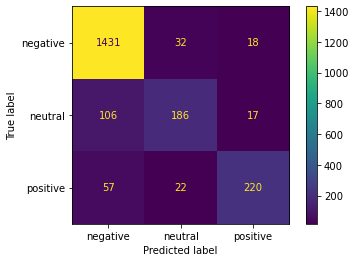

In [85]:
plot_confusion_matrix(lrgrid3.best_estimator_, X_test_vec, y_test);

### Final model results 

Correctly predicted 96% of Negative

Correctly predicted 73% of Positive

Correctly predicted 60% of Positive

### Insight

With a larger corpus of tweets further steps can be taken to analyze most frequent and meaningful words that occur in tweets that express negative sentiment.

## Conclusion

Our model can be used to identify negative tweets for further exploration and analysis. With access to larger corpus of tweets further steps can be taken to analyze most frequent and meaningful words that occur in tweets that express negative sentiment. Those words would be indicative of the reason for customers dissatisfaction.